# Попрактикуемся с тем, что изучили

Будем практиковаться на датасете:
https://www.kaggle.com/c/avito-demand-prediction

Ваша задача:
1. Создать Dataset для загрузки данных (используем только числовые данные)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

Вопросы? в личку @Kinetikm

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

## Создать Dataset для загрузки данных (используем только числовые данные)

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   item_id               1503424 non-null  object 
 1   user_id               1503424 non-null  object 
 2   region                1503424 non-null  object 
 3   city                  1503424 non-null  object 
 4   parent_category_name  1503424 non-null  object 
 5   category_name         1503424 non-null  object 
 6   param_1               1441848 non-null  object 
 7   param_2               848882 non-null   object 
 8   param_3               640859 non-null   object 
 9   title                 1503424 non-null  object 
 10  description           1387148 non-null  object 
 11  price                 1418062 non-null  float64
 12  item_seq_number       1503424 non-null  int64  
 13  activation_date       1503424 non-null  object 
 14  user_type             1503424 non-

In [ ]:
missings = (len(df) - df.count()) / len(df)

In [ ]:
missings

item_id                 0.000000
user_id                 0.000000
region                  0.000000
city                    0.000000
parent_category_name    0.000000
category_name           0.000000
param_1                 0.040957
param_2                 0.435368
param_3                 0.573734
title                   0.000000
description             0.077341
price                   0.056778
item_seq_number         0.000000
activation_date         0.000000
user_type               0.000000
image                   0.074888
image_top_1             0.074888
deal_probability        0.000000
dtype: float64

In [ ]:
from torch.nn.functional import normalize
# Если я правильно поняла задание, почти всю предобработку, включая генерацию признаков,
# нужно было уложить в Dataset. На занятии предлагалось положить генерацию в  getitem,
#  и  у меня получилась ситуация, в которой признаки генерируются все сразу только при 
#  вызове любой строки по индексу. То есть я вызываю просто custumhead (аналог df.head,
#  т.к. после обработки датасетом все стандартные функции не работают), он возвращает мне 
#  первые пять строк датасета без изменений, но если вызвать что-то вроде df[0], 
#  признаки тут-же появляются, и после повторного вызова customhead  они уже видны.

# Я не стала это оставлять в основном датасете, но в конце ноутбука пример из датасета periods
#  1) Вопрос первый - так и должно быть или у меня руки растут не из того места?
#  2) Вопрос второй - если все функции перестают работать после Dataset, как проводить EDA?
#  или в принципе это не нужно делать, и метод предназначен для обработки изображений, а не 
#  csv? Или сначала EDA, потом разбиение train_test_split и переписать Dataset чтобы принимал
#  уже готовые X_train, y_train и т.д?

In [ ]:
class NewAvito(torch.utils.data.Dataset):
    
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ind):
        val = self.df.iloc[ind]
        return val
    
    def featuregenerator(self):
        self.df['description'] = self.df['description'].astype(str)
        len_list = []
        for i in self.df['description']:
            len_list.append(len(i))

        self.df['len_description'] = len_list

        parent_count = self.df['parent_category_name'].value_counts().reset_index().\
        rename(columns={'index': 'parent_category_name','parent_category_name': 'parent_category_name_count' })
        self.df = self.df.merge(parent_count, on=['parent_category_name'], how='left')
        self.df['parent_category_name_count_%'] = (self.df['parent_category_name_count'] / len(self.df['parent_category_name'])) * 100


        category_count = self.df['category_name'].value_counts().reset_index().\
        rename(columns={'index':'category_name', 'category_name':'category_count'})
        self.df = self.df.merge(category_count, on=['category_name'], how='left')
        self.df['category_count_%'] = (self.df['category_count'] / len(self.df['category_name'])) * 100

        region_count = self.df['region'].value_counts().reset_index().\
        rename(columns={'index':'region', 'region':'region_count'})
        self.df = self.df.merge(region_count, on=['region'], how='left')
        self.df['region_count_%'] = (self.df['region_count'] / len(self.df['region'])) * 100
        
        city_count = self.df['city'].value_counts().reset_index().\
        rename(columns={'index':'city', 'city':'city_count'})
        self.df = self.df.merge(city_count, on=['city'], how='left')
        self.df['city_count_%'] = (self.df['city_count'] / len(self.df['city'])) * 100
        return self.df
        
        # Как обработать эти признаки не знала, благо помогли товарищи по курсу
    def customencoder(self):
        encode_columns = ['activation_date', 'user_type', 'param_1']
        for el in encode_columns:
            self.df[el] = LabelEncoder().fit_transform(self.df[el])
        return self.df    
     
         #Очень много выбросила из данных - в title, image энкодер не поможет,
         #а как еще их обработать не знаю, но очень хотела-бы знать)
    def customdrop(self):
        self.df.drop(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name','param_2', 'param_3','title', 'description','image', 'parent_category_name_count',
       'category_count','region_count', 'city_count'],axis=1,inplace=True)
        self.df.dropna(subset=['param_1','image_top_1', 'price'], inplace=True)
        return self.df
    
    
    def customsplit(self):
        y = self.df['deal_probability']
        X = self.df.drop(['deal_probability'], axis=1)   
        return torch.FloatTensor(X.values), torch.FloatTensor(y.values)
    
    
    def customhead(self, n):
        if n < 51: 
            head_val = self.df.iloc[0 : n]
            return head_val
        else:
            raise RuntimeError
            

In [ ]:
new_df = NewAvito('/content/drive/MyDrive/train.csv')

In [ ]:
start = len(new_df)

In [ ]:
new_df.featuregenerator()
new_df.customencoder()
new_df.customdrop()

,param_1,price,item_seq_number,activation_date,user_type,image_top_1,deal_probability,len_description,parent_category_name_count_%,category_count_%,region_count_%,city_count_%
0,248,400.0,2,13,1,1008.0,0.12789,58,46.402279,6.634655,6.283989,4.230477
1,121,3000.0,19,11,1,692.0,0.00000,41,11.894382,4.325792,4.882655,2.785309
2,83,4000.0,9,5,1,3032.0,0.43177,99,11.507599,1.798295,5.986003,3.480256
3,37,2200.0,286,10,0,796.0,0.80323,22,46.402279,6.634655,5.406592,1.023996
4,277,40000.0,3,1,1,2264.0,0.20797,24,5.310478,4.156778,3.259094,2.225786
...,...,...,...,...,...,...,...,...,...,...,...,...
1503418,125,500.0,10,2,1,387.0,0.12869,92,46.402279,18.807269,1.949084,1.500641
1503419,104,300.0,7,5,1,88.0,0.25019,3,46.402279,17.982884,4.170746,3.107573
1503420,268,200.0,1,13,1,1191.0,0.60000,250,4.282558,4.282558,9.406262,4.232871
1503422,104,350.0,33,7,1,87.0,0.00000,42,46.402279,17.982884,4.170746,0.262135


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
stop = len(new_df)

In [ ]:
# многовато как-то данных потеряла, хотя мои рассчеты в основном показывали 
# 2-3%, за вычетом второго и третьего параметров, которые я удалила из датасета
start - stop

171799

In [ ]:
X, y =  new_df.customsplit()

In [ ]:
# Не смогла отскалировать при помощи PyTorch, взяла sklearn
# 3) Вопрос третий - нужно ли было это вообще делать и если нужно, то как лучше
scaler = MinMaxScaler()
Scaled_X = torch.tensor(scaler.fit_transform(X))

In [ ]:
new_df[0]

param_1                          248.000000
price                            400.000000
item_seq_number                    2.000000
activation_date                   13.000000
user_type                          1.000000
image_top_1                     1008.000000
deal_probability                   0.127890
len_description                   58.000000
parent_category_name_count_%      46.402279
category_count_%                   6.634655
region_count_%                     6.283989
city_count_%                       4.230477
Name: 0, dtype: float64

## Обернуть его в Dataloader

#### train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [ ]:
# df
X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(Scaled_X, y,
                                                               random_state=13,
                                                               test_size=0.25)

In [ ]:
X_df_train.shape, y_df_train.shape

(torch.Size([998718, 11]), torch.Size([998718]))

In [ ]:
df_dataloader_train = torch.utils.data.DataLoader(list((zip(X_df_train, y_df_train))),
                                           batch_size=128, 
                                           shuffle=True,
                                           num_workers=2)
df_dataloader_test = torch.utils.data.DataLoader(list((zip(X_df_test, y_df_test))),
                                           batch_size=128, 
                                           shuffle=True,
                                           num_workers=2)

In [ ]:
len(df_dataloader_train)

7803

## Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов).Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)

In [ ]:
# функция активации только в конце
class MyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        #self.leakyrelu = torch.nn.LeakyReLU()
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        #self.leakyrelu = torch.nn.LeakyReLU()
        self.bn3 = nn.BatchNorm1d(64)
        self.dp2 = nn.Dropout(0.25)
        self.fc5 = nn.Linear(64, output_dim)
        self.relu = torch.nn.ReLU()
 
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.fc2(x)
        #x = self.leakyrelu(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        #x = self.leakyrelu(x)
        x = self.bn3(x)
        x = self.dp2(x)
        x = self.fc5(x)
        x = self.relu(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.fc2(x)
        #x = self.leakyrelu(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        #x = self.leakyrelu(x)
        x = self.bn3(x)
        x = self.dp2(x)
        x = self.fc5(x)
        x = self.relu(x)
        
        return x    

## Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать

In [59]:
# В метриках на каггле описана обычная rmse, здесь логарифмированная
# Реализовала и испытаю обе

def RMSE(y, preds):
    return torch.sqrt(torch.mean((y - preds) ** 2))
def RMSLE (preds, y):
    return torch.sqrt(torch.mean((torch.log(preds + 1) - torch.log(y + 1)) ** 2))
    

In [ ]:
# Этот кусок кода я утащила - не разобралась сама как считать ошибку (точнее, как собрать результат)
# к своему стыду, даже в готовом коде не разобралась.
# 4) Вопрос четвертый - как это работает в плане подсчета ошибки и какие альтернативы есть
def training(train_loader, model, criterion, optimizer, epochs=5, n=200):
    array_loss = []
    for epoch in range(epochs):  
        running_loss = 0.0
        array_loss_batches = []
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0], data[1]
            # обнуляем градиент
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # выводим статистику о процессе обучения
            running_loss += loss.item()
            # печатаем каждые n mini-batches
            if i % n == 0:
                array_loss_batches.append(running_loss / (i+1))                 
        array_loss.extend(array_loss_batches)    
    return array_loss

In [ ]:
# RMSE
criterion = RMSE

In [ ]:
SGD_model = MyNet(11, 1)
SGD_optimizer = torch.optim.SGD(SGD_model.parameters(), lr=0.01)
SGD_loss = training(df_dataloader_train,SGD_model, criterion, SGD_optimizer)

In [ ]:
ADAM_model = MyNet(11, 1)
ADAM_optimizer = torch.optim.Adam(ADAM_model.parameters())
ADAM_loss = training(df_dataloader_train,ADAM_model, criterion, ADAM_optimizer)

In [ ]:
RMSprop_model = MyNet(11, 1)
RMSprop_optimizer = torch.optim.RMSprop(RMSprop_model.parameters())
RMSprop_loss = training(df_dataloader_train, RMSprop_model, criterion, RMSprop_optimizer)

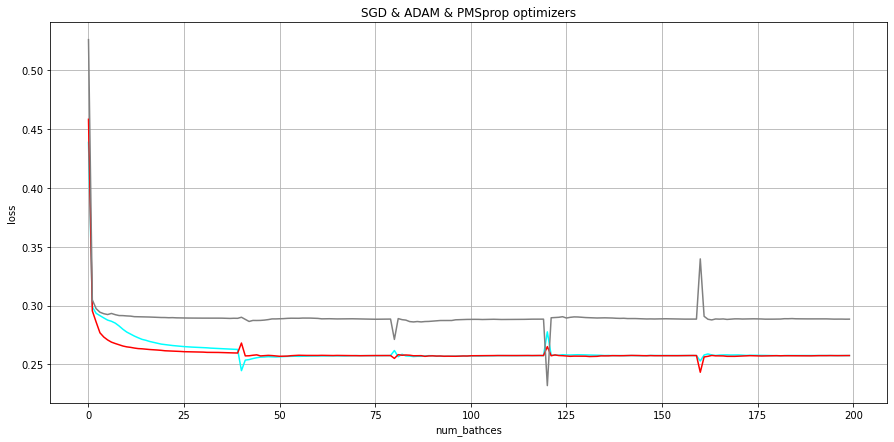

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(SGD_loss, color='cyan', label='SGD')
ax.plot(ADAM_loss, color='red', label='ADAM')
ax.plot(RMSprop_loss, color='gray', label='RMSprop')
ax.set(title='SGD & ADAM & PMSprop optimizers',
      xlabel='num_bathces',
      ylabel='loss')
ax.grid(True)

In [ ]:
# RMSLE
criterion = RMSLE

In [ ]:
SGD_model = MyNet(11, 1)
SGD_optimizer = torch.optim.SGD(SGD_model.parameters(), lr=0.01)
SGD_loss = training(df_dataloader_train,SGD_model, criterion, SGD_optimizer)

In [ ]:
ADAM_model = MyNet(11, 1)
ADAM_optimizer = torch.optim.Adam(ADAM_model.parameters())
ADAM_loss = training(df_dataloader_train,ADAM_model, criterion, ADAM_optimizer)

In [ ]:
RMSprop_model = MyNet(11, 1)
RMSprop_optimizer = torch.optim.RMSprop(RMSprop_model.parameters())
RMSprop_loss = training(df_dataloader_train, RMSprop_model, criterion, RMSprop_optimizer)

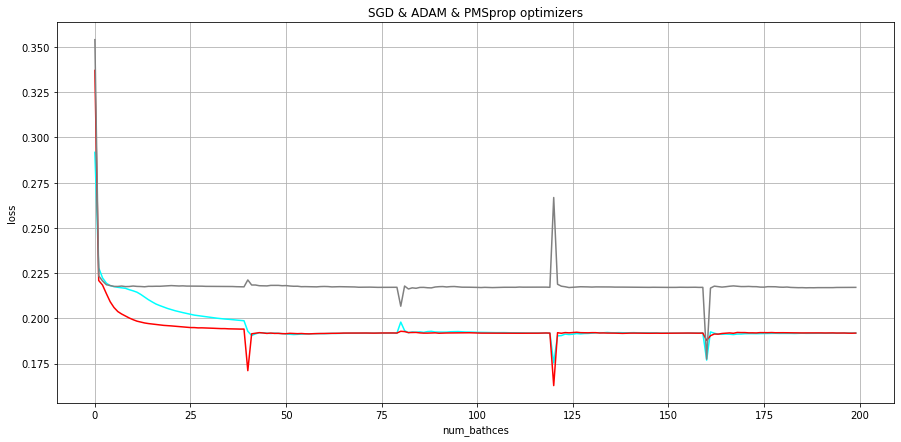

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(SGD_loss, color='cyan', label='SGD')
ax.plot(ADAM_loss, color='red', label='ADAM')
ax.plot(RMSprop_loss, color='gray', label='RMSprop')
ax.set(title='SGD & ADAM & PMSprop optimizers',
      xlabel='num_bathces',
      ylabel='loss')
ax.grid(True)

In [58]:
# добавила LeakyReLU, ошибка меньше не стала особо, но ее скачки сильно уменьшились. Почему так?
class MyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.leakyrelu = torch.nn.LeakyReLU()
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.leakyrelu = torch.nn.LeakyReLU()
        self.bn3 = nn.BatchNorm1d(64)
        self.dp2 = nn.Dropout(0.25)
        self.fc5 = nn.Linear(64, output_dim)
        self.relu = torch.nn.ReLU()
 
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.leakyrelu(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.leakyrelu(x)
        x = self.bn3(x)
        x = self.dp2(x)
        x = self.fc5(x)
        x = self.relu(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.leakyrelu(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.leakyrelu(x)
        x = self.bn3(x)
        x = self.dp2(x)
        x = self.fc5(x)
        x = self.relu(x)
        
        return x    

In [60]:
# RMSLE
criterion = RMSLE
SGD_model = MyNet(11, 1)
SGD_optimizer = torch.optim.SGD(SGD_model.parameters(), lr=0.01)
SGD_loss = training(df_dataloader_train,SGD_model, criterion, SGD_optimizer)
ADAM_model = MyNet(11, 1)
ADAM_optimizer = torch.optim.Adam(ADAM_model.parameters())
ADAM_loss = training(df_dataloader_train,ADAM_model, criterion, ADAM_optimizer)
RMSprop_model = MyNet(11, 1)
RMSprop_optimizer = torch.optim.RMSprop(RMSprop_model.parameters())
RMSprop_loss = training(df_dataloader_train, RMSprop_model, criterion, RMSprop_optimizer)

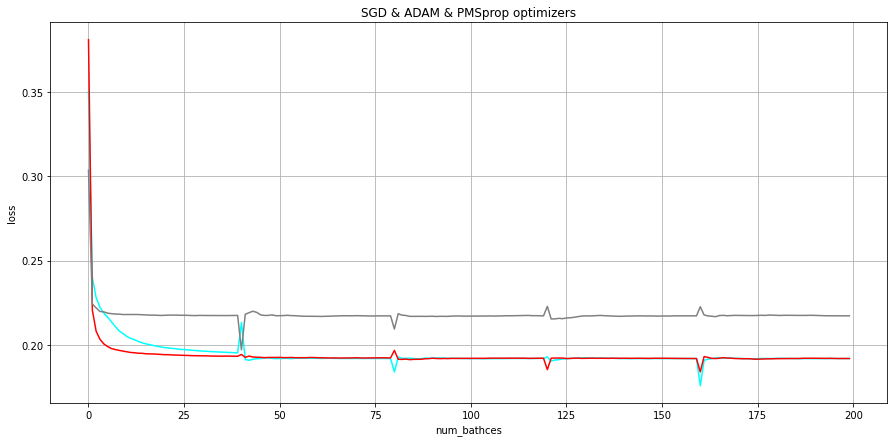

In [61]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(SGD_loss, color='cyan', label='SGD')
ax.plot(ADAM_loss, color='red', label='ADAM')
ax.plot(RMSprop_loss, color='gray', label='RMSprop')
ax.set(title='SGD & ADAM & PMSprop optimizers',
      xlabel='num_bathces',
      ylabel='loss')
ax.grid(True)

## Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

In [ ]:
# RMSLE лучше отрабатывает, ошибка меньше. Из оптимайзеров SGD и ADAM почти одинаково отрабатывают,
# RMSprop больше ошибку дает.
# 5) Вопрос пятый - откуда эти скачки ошибок во всех трех случаях? Из-за использования батчей?

In [ ]:
class NewPeriods(torch.utils.data.Dataset):
    
    def __init__(self, csv_file):
        self.periods = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.periods)
    
    def customdrop(self):
        return df.dropna(subset=['activation_date'])
    
    def customsplit(self):
        X = self.periods.iloc[:, : -1]
        y = self.periods.iloc[:, -1]
        return X, y
    
    def __getitem__(self, ind):
        self.periods['activation_date'] = pd.to_datetime(self.periods["activation_date"])
        self.periods['date_from'] = pd.to_datetime(self.periods['date_from'])
        self.periods['date_to'] = pd.to_datetime(self.periods['date_to'])
        self.periods['before_start'] = (self.periods['date_from'] - self.periods['activation_date']).dt.days
        self.periods['active_life'] = (self.periods['date_to'] - self.periods['date_from']).dt.days
        self.periods['life_duration'] = (self.periods['date_to'] - self.periods['activation_date']).dt.days
        val = self.periods.iloc[ind]
        return val
    
    def customhead(self, n):
        if n < 51: 
            head_val = self.periods.iloc[0 : n]
            return head_val
        else:
            raise RuntimeError

In [ ]:
new_p = NewPeriods('/content/drive/MyDrive/periods_train.csv')

In [ ]:
# А вот это про метод getitem, что я выше описывала
new_p.customhead(5)

,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28


In [ ]:
new_p[3]

item_id                   80bf58082ad3
activation_date    2017-03-19 00:00:00
date_from          2017-03-19 00:00:00
date_to            2017-03-28 00:00:00
before_start                       0.0
active_life                          9
life_duration                      9.0
Name: 3, dtype: object

In [ ]:
new_p.customhead(5)

,item_id,activation_date,date_from,date_to,before_start,active_life,life_duration
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,29.0,1,30.0
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,27.0,3,30.0
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,14.0,13,27.0
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,0.0,9,9.0
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,1.0,13,14.0
